In [66]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


Load Data

In [67]:
df = pd.read_csv('housing_data_cleaned.csv')

In [68]:
df.dtypes

Unnamed: 0              int64
Zip_Code                int64
Dwelling_Type          object
Nr_Bedrooms             int64
Nr_Bathrooms          float64
Approx_SQFT             int64
Price_per_SqFt        float64
Dwelling_Styles        object
Year_Built              int64
Approx_Lot_SqFt         int64
Pool                   object
HOA_Fee               float64
Land_Lease_Fee         object
Clubhouse_Rec_Room     object
Basement               object
RV_Gate                object
List_Price              int64
Sold_Price              int64
Building_Style         object
Gated_Community        object
Workout_Facility       object
Garage_Spaces         float64
Carport_Spaces        float64
Loan_Type              object
Payment_Type           object
HOA_Missing             int64
Buyer_Concession      float64
Seller_Concession     float64
diff_List_Sold          int64
dtype: object

In [69]:
# dropping columns 'List_Price', and 'diff_List_Sold' conducive to data leakage
columns_to_drop = ['List_Price','diff_List_Sold']

df.drop(columns_to_drop, axis=1, inplace=True)

**Find if any column contains NaN values** -- looks like 'HOA_Fee' contains NaN values

In [70]:
df.dtypes

Unnamed: 0              int64
Zip_Code                int64
Dwelling_Type          object
Nr_Bedrooms             int64
Nr_Bathrooms          float64
Approx_SQFT             int64
Price_per_SqFt        float64
Dwelling_Styles        object
Year_Built              int64
Approx_Lot_SqFt         int64
Pool                   object
HOA_Fee               float64
Land_Lease_Fee         object
Clubhouse_Rec_Room     object
Basement               object
RV_Gate                object
Sold_Price              int64
Building_Style         object
Gated_Community        object
Workout_Facility       object
Garage_Spaces         float64
Carport_Spaces        float64
Loan_Type              object
Payment_Type           object
HOA_Missing             int64
Buyer_Concession      float64
Seller_Concession     float64
dtype: object

In [71]:
df.columns[df.isnull().any()].tolist()

['HOA_Fee']

In [72]:
# replace all NaN values with 0 in HOA_Fee column
df['HOA_Fee'] = df['HOA_Fee'].fillna(0)  

In [73]:
# sanity check for Nan values. 
df.columns[df.isnull().any()].tolist()
# it looks good

[]

### 1. Turn categorical values in numerical using get_dummies

In [74]:
only_objects = df.select_dtypes('object').info()  # there are 12 columns of object type 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3117 entries, 0 to 3116
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Dwelling_Type       3117 non-null   object
 1   Dwelling_Styles     3117 non-null   object
 2   Pool                3117 non-null   object
 3   Land_Lease_Fee      3117 non-null   object
 4   Clubhouse_Rec_Room  3117 non-null   object
 5   Basement            3117 non-null   object
 6   RV_Gate             3117 non-null   object
 7   Building_Style      3117 non-null   object
 8   Gated_Community     3117 non-null   object
 9   Workout_Facility    3117 non-null   object
 10  Loan_Type           3117 non-null   object
 11  Payment_Type        3117 non-null   object
dtypes: object(12)
memory usage: 292.3+ KB


In [75]:
df = pd.get_dummies(df,columns=['Dwelling_Type'], dtype='int', prefix='Type')
df = pd.get_dummies(df,columns=['Dwelling_Styles'], dtype='int',prefix='Style')
df= pd.get_dummies(df,columns=['Pool'],dtype='int', prefix='Pool')
df= pd.get_dummies(df,columns=['Land_Lease_Fee'],dtype='int', prefix='Land')
df= pd.get_dummies(df,columns=['Clubhouse_Rec_Room'],dtype='int', prefix='Club')
df= pd.get_dummies(df,columns=['Basement'], dtype='int',prefix='Base')
df= pd.get_dummies(df,columns=['RV_Gate'], dtype='int', prefix='RV_Gate')
df= pd.get_dummies(df,columns=['Building_Style'],dtype='int', prefix='Bldg_style')
df= pd.get_dummies(df,columns=['Gated_Community'],dtype='int', prefix='Gated')
df= pd.get_dummies(df,columns=['Workout_Facility'],dtype='int', prefix='Fittness')
df= pd.get_dummies(df,columns=['Loan_Type'],dtype='int', prefix='Loan')
df= pd.get_dummies(df,columns=['Payment_Type'],dtype='int', prefix='Payment')


In [76]:
df.shape

(3117, 65)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3117 entries, 0 to 3116
Data columns (total 65 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3117 non-null   int64  
 1   Zip_Code                           3117 non-null   int64  
 2   Nr_Bedrooms                        3117 non-null   int64  
 3   Nr_Bathrooms                       3117 non-null   float64
 4   Approx_SQFT                        3117 non-null   int64  
 5   Price_per_SqFt                     3117 non-null   float64
 6   Year_Built                         3117 non-null   int64  
 7   Approx_Lot_SqFt                    3117 non-null   int64  
 8   HOA_Fee                            3117 non-null   float64
 9   Sold_Price                         3117 non-null   int64  
 10  Garage_Spaces                      3117 non-null   float64
 11  Carport_Spaces                     3117 non-null   float

## 2. Train/Test Split

In [78]:
# manual checking for the partition sizes for 70/30 split
len(df) * .7, len(df) * .3

(2181.8999999999996, 935.0999999999999)

In [79]:
# partitioning the data into training and testing in 70/30 splits, with predicted value is "Sold_Price"

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Sold_Price'), 
                                                    df.Sold_Price, test_size=0.3, 
                                                    random_state=47)

In [80]:
# partition sizes are consistent with the manual partitioning sizes calculated above
X_train.shape, X_test.shape

((2181, 64), (936, 64))

In [81]:
y_train.shape, y_test.shape

((2181,), (936,))

In [82]:
# Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

Unnamed: 0                 int64
Zip_Code                   int64
Nr_Bedrooms                int64
Nr_Bathrooms             float64
Approx_SQFT                int64
                          ...   
Payment_Fixed              int32
Payment_Graduated          int32
Payment_Interest Only      int32
Payment_Missing            int32
Payment_Other              int32
Length: 64, dtype: object

In [83]:
# Repeat this check for the test split in `X_test`
X_test.dtypes

Unnamed: 0                 int64
Zip_Code                   int64
Nr_Bedrooms                int64
Nr_Bathrooms             float64
Approx_SQFT                int64
                          ...   
Payment_Fixed              int32
Payment_Graduated          int32
Payment_Interest Only      int32
Payment_Missing            int32
Payment_Other              int32
Length: 64, dtype: object

### Determine how good the mean is as a predictor. Consider "Average Sold Price" is the best guess

In [84]:
#Calculate the mean of `y_train`
train_mean = y_train.mean()
train_mean

649888.3635946814

In [85]:
# Calculate same thing by fitting the dummy regressor on the training data and calling mean strategy
# Then print the object's `constant_` attribute and verify it's the same as the mean above

dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

DummyRegressor()

array([[649888.36359468]])

How good is this? How closely does this match, or explain, the actual values? Metrics will help answering these questions

### Metrics:  
### R-squared or coefficient of determination

In [86]:
# Manually Calculate the R^2 
def r_squared(y, ypred):
    """R-squared score.    
    Calculate the R-squared, or coefficient of determination, of the input.
    Arguments:
               y -- the observed values
               ypred -- the predicted values
    """
    ybar = np.sum(y) / len(y)            # I know I could have used np.mean(y)
    sum_sq_tot = np.sum((y - ybar)**2)   # total sum of squares error
    sum_sq_res = np.sum((y - ypred)**2)  # residual sum of squares error
    R2 = 1.0 - sum_sq_res / sum_sq_tot
    return R2

Make the predictions by creating an array "y_tr_pred" of length equal to the size of the training set with each array element equal to the single value of the mean.

In [87]:
y_tr_pred_ = train_mean * np.ones(len(y_train)) # np.ones(len(y_train)) creates an array of ones with the same length as y_train
y_tr_pred_[:5]

array([649888.36359468, 649888.36359468, 649888.36359468, 649888.36359468,
       649888.36359468])

I can obtain same thing using the sklearn dummy regressor baseline model: dumb_reg = DummyRegressor(strategy='mean')

In [88]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([649888.36359468, 649888.36359468, 649888.36359468, 649888.36359468,
       649888.36359468])

The DummyRegressor produces exactly the same results and saves me from having to mess about broadcasting the mean (or whichever other statistic is called. It also gives an object with fit() and predict() methods as well, which can be used as conveniently as any other sklearn estimator.

In [89]:
r_squared(y_train, y_tr_pred)  # call r_squared function defined previosuly, using arguments y_train, y_tr_pred

0.0

As expected, if I use the average value as my prediction, I get an $R^2$ of zero _on the training set_. What if I use this "model" to predict unseen values from the test set? Of course, the "model" is trained on the training set; I still use the training set mean as my prediction.

In [90]:
y_te_pred = train_mean * np.ones(len(y_test))
r_squared(y_test, y_te_pred)  # call r_squared function defined previosuly, using arguments y_test, y_te_pred

-0.0078084421886748245

Performance on a test set is expected to be slightly worse than on the training set. As I'm getting an  𝑅2
  of zero on the training set, there's nowhere to go but negative!  -0.0078

Next: I use Metrics that summarise the difference between predicted and actual values which are mean absolute error and mean squared error.

This is very simply the average of the absolute errors:

$$MAE = \frac{1}{n}\sum_i^n|y_i - \hat{y}|$$

𝑦̂ 
  are our predicted values for the depended variable

In [91]:
#Calculate the MAE according to formula above

def mae(y, ypred):
    """Mean absolute error.    
    Calculate the mean absolute error of the arguments
    Arguments:
                  y -- the observed values
                  ypred -- the predicted values
    """
    abs_error = np.abs(y - ypred)
    mae = np.mean(abs_error)
    return mae

In [92]:
mae(y_train, y_tr_pred)

347574.7837341418

In [93]:
mae(y_test, y_te_pred)  

313711.9215035054

#### the MAE was less when used on test set compared to train set, which is against what was expected.  Test set is unseen so we generally expect Test MAE to be higher as it more difficult to perform well on unseen data.
 It might happen "by chance" that the test set is relatively easier (than the training set) for the model to score higher accuracy hence leading to lower Test MAE. Running 1000 different train/test splits or cross validations would be some exploration methods to further analyze. For now, I continue with sklearn metrics.
 


Mean absolute error is one of the most intuitive of all the metrics, this essentially says that, on average, expect to be off by around $313711 if the guessed Sold_Price was based on an average of known values.

### Next metric: Mean Squared Error calculated below as :   

$$MSE = \frac{1}{n}\sum_i^n(y_i - \hat{y})^2$$

MSE is a common metric (and an important one internally for optimizing machine learning models), this is simply the average of the square of the errors:

In [94]:
# Calculate the MSE according to formula above

def mse(y, ypred):
    """Mean square error.     
    Calculate the mean square error of the arguments
    Arguments:
            y -- the observed values
            ypred -- the predicted values
    """
    sq_error = (y - ypred)**2
    mse = np.mean(sq_error)
    return mse

In [95]:
mse(y_train, y_tr_pred)

407213445225.1448

In [96]:
mse(y_test, y_te_pred)

306122830945.3079

This result is consistent with the findings of MAE where against expectations, the MSE on test data was less than MSE on train data. Same conclusions apply here

To convert this back to the measurement space, take the square root, to form the root mean square error thus:

In [97]:
np.sqrt([mse(y_train, y_tr_pred), mse(y_test, y_te_pred)])

array([638132.78024651, 553283.68035331])

### sklearn.metrics: Calculate R-squared and Mean Absolute Error using sklearn.metrics

In [98]:
# R-squared
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.0078084421886748245)

In [99]:
# Mean absolute error
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(347574.7837341418, 313711.9215035054)

In [100]:
# Mean Squarred error
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(407213445225.1448, 306122830945.3079)

In [101]:
# train set - sklearn
r2_score(y_train, y_tr_pred)

0.0

In [102]:
# test set - sklearn
r2_score(y_test, y_te_pred)

-0.0078084421886748245

Conclusion:  The two error metrics MSE and MAE are employed. The MSE is typically larger than MAE, it penalizes larger errors more (because of the squaring operation). On the other hand MAE is more robust to the outliers sinmce it considers absolute differences. Results are conforming with expectations.

## Initial Models:  
### Steps: 
#### 1)   Scaling, 
#### 2)    Train the model on the train split
#### 3)    Make predictions using the model on both train and test splits
#### 4)    Assess model performance

In [128]:
# As I have features measured in many different units, with numbers that vary by orders of magnitude, 
# I start off by scaling them to put them all on a consistent scale. The StandardScaler scales each feature to zero mean and 
# unit variance.

### 1) Scaling

In [129]:
# Call the StandardScaler`s fit method on `X_tr` to fit the scaler
# then use it's `transform()` method to apply the scaling to both the train and test split
# data (`X_tr` and `X_te`), naming the results `X_tr_scaled` and `X_te_scaled`, respectively
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

StandardScaler()

### 2) Train the model on the train split

In [131]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

### 3)    Make predictions using the model on both train and test splits

In [132]:
#Call the `predict()` method of the model (`lm`) on both the (scaled) train and test data
#Assign the predictions to `y_tr_pred` and `y_te_pred`, respectively
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

### 4)    Assess model performance

In [137]:
# r^2 - train, test
median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
median_r2

(0.9132463141655233, 0.8815040134809363)

In [140]:
# calculate the mean absolute error scores using `sklearn`'s `mean_absolute_error` function
# as I did above for R^2
# MAE - train, test
score_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
score_mae

(105704.67705999361, 102426.76991530623)

In [141]:
#And also I do the same using `sklearn`'s `mean_squared_error`
# MSE - train, test
score_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
score_mse

(35327267294.637115, 35993275438.43077)

In [142]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(105704.67705999361, 102426.76991530623)

In [143]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(35327267294.637115, 35993275438.43077)

### Pipelines

In [175]:
#Code task 17#
#Modify the `SelectKBest` step to use a value of 15 for k
pipe15 = make_pipeline( 
    StandardScaler(),
    SelectKBest(f_regression, k=15),
    LinearRegression()
)

In [176]:
type(pipe15)

sklearn.pipeline.Pipeline

In [177]:
hasattr(pipe15, 'fit'), hasattr(pipe15, 'predict')

(True, True)

### Fit the pipeline

In [178]:
#Call the pipe's `fit()` method with `X_train` and `y_train` as arguments
pipe15.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=15,
                             score_func=<function f_regression at 0x0000023707F2DDA0>)),
                ('linearregression', LinearRegression())])

#### Make predictions on the train and test sets

In [179]:
y_tr_pred = pipe15.predict(X_train)
y_te_pred = pipe15.predict(X_test)

#### Assess performance

In [180]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.9106978734000615, 0.8797257641685882)

### Assessing performance using cross-validation

In [181]:
cv_results = cross_validate(pipe, X_train, y_train, cv=5)

In [182]:
cv_scores = cv_results['test_score']
cv_scores

array([-8.40094605e+22, -4.49158960e+23,  9.13646814e-01, -2.09541751e+22,
       -4.96894381e+23])

In [183]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([-6.43993323e+23,  2.23586533e+23])

### Hyperparameter search using GridSearchCV

In [184]:
#Call `pipe`'s `get_params()` method to get a dict of available parameters and print their names
#using dict's `keys()` method
pipe15.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'selectkbest', 'linearregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__positive'])

In [185]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [186]:
lr_grid_cv = GridSearchCV(pipe15, param_grid=grid_params, cv=5, n_jobs=-1)

In [187]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(k=15,
                                                    score_func=<function f_regression at 0x0000023707F2DDA0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [191]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [192]:
#Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 9}

In [190]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(105039.05719174129, 103138.01222530584)

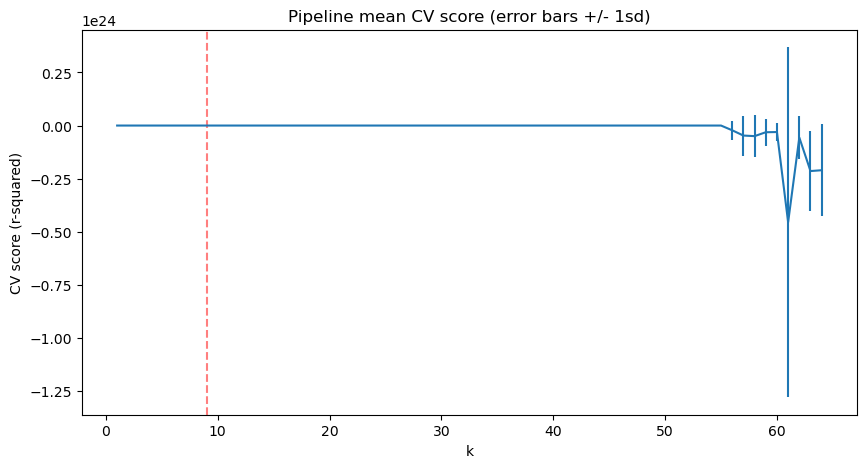

In [193]:
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [194]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [195]:
#Get the linear model coefficients from the `coef_` attribute and store in `coefs`,
#get the matching feature names from the column names of the dataframe,
#and display the results as a pandas Series with `coefs` as the values and `features` as the index,
#sorting the values in descending order
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

Approx_SQFT       434013.527844
Price_per_SqFt    356001.010374
Pool_no_pool       24514.300052
Nr_Bathrooms       22462.474690
Carport_Spaces     17385.560137
Pool_Private       11530.183588
Type_SF           -14754.990132
Garage_Spaces     -44074.185023
Nr_Bedrooms       -60232.687632
dtype: float64

### Random Forest Model

#### Define the pipeline

In [196]:
#Define a pipeline comprising the steps:
#SimpleImputer() with a strategy of 'median'
#StandardScaler(),
#and then RandomForestRegressor() with a random state of 47
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

#### Fit and assess performance using cross-validation

In [197]:
#Call `cross_validate` to estimate the pipeline's performance.
#Pass it the random forest pipe object, `X_train` and `y_train`,
#and get it to use 5-fold cross-validation
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [198]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.98661409, 0.98723855, 0.96978419, 0.9909751 , 0.86067933])

In [199]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.9590582534244593, 0.04973046724874)

### Hyperparameter search using GridSearchCV

In [202]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        }
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None]}

In [203]:
#Call `GridSearchCV` with the random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation, and all available CPU cores (if desired)
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [204]:
#Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. This may take a minute or two.
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [205]:
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 183, 'standardscaler': None}

In [206]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.98608525, 0.98803523, 0.97046351, 0.9887326 , 0.86343847])

In [207]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.9593510104696306, 0.04842207034051612)

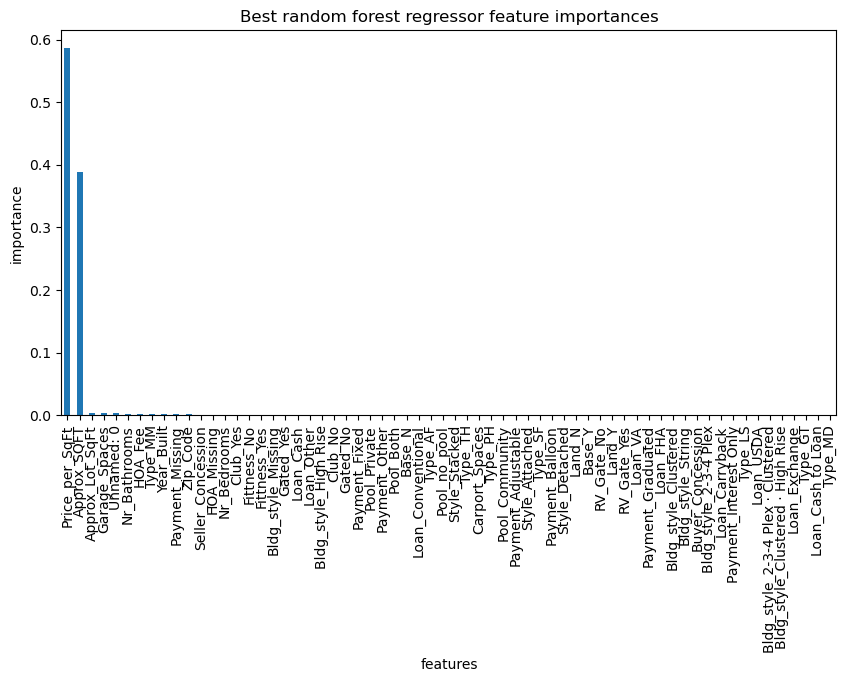

In [208]:
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

### Final Model Selection

### Linear regression model performance

In [209]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [210]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(108884.42118153562, 4496.470796638023)

In [211]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

105162.78714091633

### Random forest regression model performance

In [212]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [213]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(22764.344141574715, 5635.223763578691)

In [214]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

15075.938536266407

## Conclusion

The random forest model has a lower cross-validation mean absolute error by almost $90000. It also exhibits less variability. Verifying performance on the test set produces performance consistent with the cross-validation results.

### Data quantity assessment

In [215]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

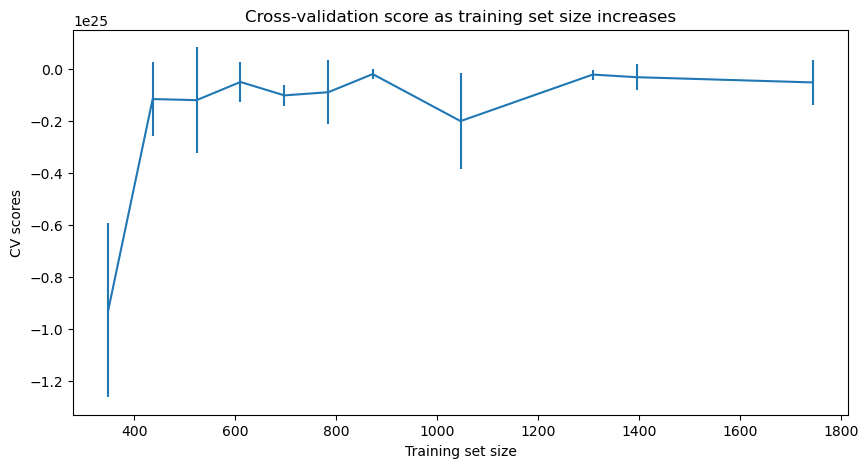

In [216]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

This shows that I seem to have plenty of data. There's an initial rapid improvement in model scores as one would expect, but it's essentially levelled off by around a sample size of 450-500.

Save best model object from pipeline

In [224]:
#Let's call this model version '1.0'
best_model = rf_grid_cv.best_estimator_
best_model.version = 1.0
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [225]:
import pandas as pd
import os
import pickle
    
    
# This utility was created because students were getting confused when they ran 
# their notebooks twice, the previous write-to-file code would do nothing and say  
# nothing. The students thought the file was over-written when in fact, it was not -
# generating hidden bugs in subsequent notebooks.

def save_file(data, fname, dname):
    """Save a datafile (data) to a specific location (dname) and filename (fname)
    
    Currently valid formats are limited to CSV or PKL."""
    
    if not os.path.exists(dname):
        os.mkdir(dname)
        print(f'Directory {dname} was created.')
        
    fpath = os.path.join(dname, fname)
    
    
    if os.path.exists(fpath):
        print("A file already exists with this name.\n")

        yesno = None
        while yesno != "Y" and yesno != "N":
            yesno = input('Do you want to overwrite? (Y/N)').strip()[0].capitalize()
            if yesno == "Y":
                print(f'Writing file.  "{fpath}"')
                _save_file(data, fpath)
                break  # Not required
            elif yesno == "N":
                print('\nPlease re-run this cell with a new filename.')
                break  # Not required
            else:
                print('\nUnknown input, please enter "Y" or "N".')

    else:  # path does not exist, ok to save the file
        print(f'Writing file.  "{fpath}"')
        _save_file(data, fpath)
        
        
        
        
        
        
def _save_file(data, fpath):
    valid_ftypes = ['.csv', '.pkl']
    
    assert (fpath[-4:] in valid_ftypes), "Invalid file type.  Use '.csv' or '.pkl'"

    # Figure out what kind of file we're dealing with by name
    if fpath[-3:] == 'csv':
        data.to_csv(fpath, index=False)
    elif fpath[-3:] == 'pkl':
        with open(fpath, 'wb') as f:
            pickle.dump(data, f)
            

In [226]:
# save the model

modelpath = '../Models'
save_file(best_model, 'housing_pricing_model.pkl', modelpath)

Writing file.  "../Models\housing_pricing_model.pkl"


## Summary

Summary preprocessing and training

In this notebook I focused on pre-processing and training a model to obtain the Sold_Price based on most significant listing features, regardless of zipcodes. To gain a baseline idea of performance of the model, first I use the average sold price as a predictor and assess its performance. This first model represents the baseline performance comparison for subsequent models. 
To do this, I partitioned the data in a training and a test data set using a 70/30 train/test split. I removed the categorical features and kept only numerical. The average sold price is 649888. Same value is found by using the sklearn DummyRegressor, after applying the fit method to the train data and using the mean strategy. 

The predicted trained target y_tr_pred is 649888, I used two methods to calculate it:

1	Multiplying the mean value of 649888 with an array of ones of the size of train data

2	Applying the predict method on sklearn dummy regressor I got `y_tr_pre`d 649888

To verify how good this basic model explains the actual values, I use the following metrics:
-  R-squared (coefficient of determination)
-  Mean absolute error
-  Mean squared error

I used two methods to calculate the metrics, one using my own defined functions `r_squared`, `mae`, `mse` and the other by using the sklearn built in metrics `r2_score`, `mean_absolute_error` and `mean_squarred_error`. 
Given the arguments (`y_train`, `y_tr_pred`) the results were as follow:
- R-squared (coefficient of determination) = 0
- Mean absolute error = 347574.78
- Mean squared error =407213445225.14

Given the arguments (`y_test`, `y_te_pred`) the results were as follow:
- R-squared (coefficient of determination) = -0.0078
- Mean absolute error = 313711.92
- Mean squared error =306122830945.30
Same results were obtained whether I used sklearn metrics of my own defined functions. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; As there are many features measured in many different units, with numbers that vary by orders of magnitude, I start off by scaling them to put them all on a consistent scale. The `StandardScaler` scales each feature to zero mean and unit variance. The new data, after scaling, is saved as `X_tr_scaled` and `X_te_scaled`.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The `X_tr_scaled` and `X_te_scaled` are passed as arguments in `lm` linear model. I called the `fit` method to create the model. Now I can use the `lm` to make predictions by calling `predict` method, and assigning the predictions to `y_tr_pred` and `y_te_pred`, respectively.

Assessing the `lm` model performance, using the median for imputing missing values:

Passing the arguments (`y_train`, `y_tr_pred`) to sklearn metrics, I got:
- R-squared (coefficient of determination) = 0
- Mean absolute error = 347574.78
- Mean squared error =407213445225.14

Passing the arguments (`y_test`, `y_te_pred`) to sklearn metrics, I got:
- R-squared (coefficient of determination) = -0.0078
- Mean absolute error = 313711.92
- Mean squared error =306122830945.30


Using Pipelines: 
First, I define the pipeline object by using the arguments:

- StandardScaler() – to scale the features
- LinearRegression() – to train the model

Second, call the pipe's `fit()` method with `X_train` and `y_train` as arguments
Third, make predictions on train and test set, saving results in `y_tr_pred` and `y_te_pred`
Fourth, assess performance using sklearn metrics `r2_score`, `mean_absolute_error` and `mean_squared_error`, using values predicted by the pipeline object.

Passing the arguments (`y_train`, `y_tr_pred`) to sklearn metrics, I got:

- R-squared (coefficient of determination) = 0.910


Passing the arguments (`y_test`, `y_te_pred`) to sklearn metrics, I got:

- R-squared (coefficient of determination) = 0.879


These results confirm the pipeline is doing exactly what's expected

**Refining the linear model**

I suspect the model was overfitting. This is no real surprise given the number of features I blindly used. It's likely a judicious subset of features would generalize better. sklearn has a number of feature selection functions available. The one I'll use here is `SelectKBest` which selects the `k` best features. I use  `f_regression` as the `score function` because I’m performing regression for my machine learning task.

As before, 

First, I define the pipeline object as before, by using the same arguments plus the `SelectKBest()`:

- StandardScaler() 
- SelectKBest(f_regression)
- LinearRegression() 

Second, call the pipe's `fit()` method with `X_train` and `y_train` as arguments

Third, make predictions on train and test set, saving results in `y_tr_pred` and `y_te_pred`

Forth, assess performance on the train and test set, using values predicted by the new pipeline object again, based on `median` strategy:

Passing the arguments (`y_train`, `y_tr_pred`) to sklearn metrics, I got:

- Mean absolute error = 105039.05

Passing the arguments (`y_test`, `y_te_pred`) to sklearn metrics, I got:

- Mean absolute error = 103138.01


Apply a technique called `cross-validation`. I partition the training set into `k folds`, train my model on k-1 of those folds, and calculate performance on the fold not used in training. This procedure then cycles through k times with a different fold held back each time. Thus I end up building k models on k sets of data with k estimates of how the model performs on unseen data but without having to touch the test set.

**Assessing performance using cross-validation – hyperparameters using GridSearchCV**

I apply the `cross_validate` function from sklearn on `pipe15`, using `x_train` and `y_train` datasets, and set the number of `cross-validation` folds `cv = 5`, meaning the data will be split into 5 subsets (folds), and the model will be trained and evaluated 5 times, each time using a different fold as the validation set. Then I use the `cross_validate` function to return various metrics for each fold, in this case `r2_squared`. To access the results, I examine the `cv_results` dictionary key `'test_score'`, based on the scoring metrics I specified when I created pipe15, which is `f_regression`. 

   - The `f_regression` score function is suitable for regression problems.
   - It quantifies the relationship between each feature and the target variable.
   - Specifically, it calculates the `F-value` between the label and each feature.

The results are saved in `cv_scores`, an array of 5 values, representing the `F-values`. A larger `F-value` indicates greater variation between group means relative to the variation within the samples.

array([-8.40094605e+22, -4.49158960e+23,  9.13646814e-01, -2.09541751e+22,-4.96894381e+23])

Taking the mean and standard deviation I get array([-6.43993323e+23,  2.23586533e+23]), respectively. 

These results highlight that assessing model performance is inherently open to variability. I'll get different results depending on the quirks of which points are in which fold. An advantage of this is that I can also obtain an estimate of the variability, or uncertainty, in my performance estimate.

Now I want to use `cross-validation` for multiple values of k and use `cross-validatio`n to pick the value of k that gives the best performance. `make_pipeline` automatically names each step as the lowercase name of the step and the parameters of the step are then accessed by appending a double underscore followed by the parameter name. The name of the step will be `'selectkbest'` and the parameter is `'k'`.

First, I define the `GridSearchCV` function and save it in `lr_grid_cv`:

- estimator = pipeline pipe
- param_grid = grid_params previously defined as dictionary {‘selectbest_k’ : k}
- cv = 5
- n_jobs = -1 , meaning all CPU’s are used

Second, I use `cv_results` attribute on `lr_grid_cv` to obtain information about the `cross-validated` performance of the estimator over different hyperparameter settings. Specifically,

- `mean_test_score` represents the average score (performance metric) across all cross-validation folds for each combination of `hyperparameters`.
- `std_test_score` represents the standard deviation of the test scores across the folds. It indicates how much the test scores vary from fold to fold. A higher value suggests greater variability in performance.
- `param_selectbest_k` creates a list called `cv_k`. This list contains the values of the hyperparameter k used during the grid search process.

Using best_param attribute on `lr_grid_cv` I found out that there are 9 best features. This is visualized in plot titled `‘Pipeline mean CV score (error bars +/- 1sd)’`
The above suggests a good value for k is 9. There was an initial rapid increase with k, followed by a slow decline. Also noticeable is the variance of the results greatly increase above `k=9`. As I increasingly overfit, I expect greater swings in performance as different points move in and out of the train/test folds.

Which features were most useful? Step into the best model, shown below. Starting with the fitted grid search object, I get the `best_estimator_`, then the `named_steps` `'selectkbest'`, for which I call its `get_support()` method for a logical mask of the features selected. Similarly, instead of using the `'selectkbest'` named step, I can access the named step for the linear regression model and, from that, grab the model coefficients via its `coef_` attribute:
These are the 8 best features:

    - Approx_SQFT       434013.527844
    - Price_per_SqFt    356001.010374
    - Pool_no_pool       24514.300052
    - Nr_Bathrooms       22462.474690
    - Carport_Spaces     17385.560137
    - Pool_Private       11530.183588
    - Type_SF           -14754.990132
    - Garage_Spaces     -44074.185023
    - Nr_Bedrooms       -60232.687632

These results suggest that Approx_SQFT is the biggest positive feature. This makes intuitive sense and is consistent with what I saw during the EDA work. Also, I see the Price_per_SqFt is a strong positive as well.  The Pool_no_pool is an important variable too. The type of housing is inversely correlated with Sold price as well as Garage Spaces and Nr_of_Bedrooms which is counterintuitive.

**Random Forest Model**

A model that can work very well in a lot of cases is the `random forest`. For regression, this is provided by sklearn's `RandomForestRegressor` class. I also go straight from defining the pipeline to assessing performance using cross-validation. `cross_validate` will perform the fitting as part of the process. This uses the default settings for the random forest so I'll then proceed to investigate some different `hyperparameters`.

First, I define the pipeline `RF_pipe` with `make_pipeline` function that constructs a pipeline from a list of estimators (transformers and/or predictors) Unlike the regular Pipeline constructor, `make_pipeline` does not require naming the estimators explicitly. Instead, it automatically sets their names to the lowercase of their types. :

    -	StandardScaler() 
    -	RandomForestRegressor(random_state=47)

Second, fit and assess performance using cross-validation:

- Call `cross_validate` to estimate the pipeline's performance. Pass it the random forest pipe object, `X_train` and `y_train`, and get it to use 5-fold cross-validation. Save in `rf_default_cv_results`
- Results: array([0.98661409, 0.98723855, 0.96978419, 0.9909751 , 0.86067933])
- The `mean` and `stdev` are 0.959 and 0.0497, respectively

Third, hyperparameter search using `GridSearchCV`

- Call `GridSearchCV` with the random forest pipeline, passing in the `grid_params` dict for parameters to evaluate, and 5-fold cross-validation and all available CPU cores (if desired). Save in `rf_grid_cv`. Then call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments to actually start the grid search. 
- Call the `best_params_` attribute from the grid search. 
- Calling `cross_validate` function with arguments `rf_grid_cv.best_estimator_`, `X_train`, `y_train`, `cv=5`
- Then extracting the `‘test_score’` I got:

array([0.98608525, 0.98803523, 0.97046351, 0.9887326 , 0.86343847])
with `mean` of 0.959 and `stdev` of 0.0484

I've marginally improved upon the default CV results. Random forest has many more hyperparameters I could tune, but I won't dive into that here.

Next, I plot a barplot of the random forest's feature importances, assigning the `feature_importances_` attribute of `rf_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then create a pandas Series object of the feature importances, with the index given by the training data column names, sorting the values in descending order.
Encouragingly, the dominant two features are in common with your linear model:

    -	price_per_sqft
    -	Approx_SqFt
   

Certainly there seem to be two strong features here and so a model using only those would probably work well. Now I have two models I built a best `linear mode`l and a `best random forest model`. I need to finally choose between them. I can calculate the mean absolute error using cross-validation. Although cross-validate defaults to the  `r2` metric for scoring regression, I can specify the mean absolute error as an alternative via the scoring parameter.

First, I calculate **Linear regression model** performance of `lr_grid_cv` using `neg_mean_absolute_error` metric for the train set  and save it to `lr_neg_mae`. I multiply it by `-1` and calculate `mean' and `stdev` of 108884.42 and 4496.47, respectively. Using the test data set, the predicted `mean_absolute_error` is 105162.78.

Then, I calculate **Random Forest regression model** performance of `lr_grid_cv` using `neg_mean_absolute_error` metric for the train set and save it to `rf_neg_mae`. I multiply by -1 and calculate `mean` and `stdev` of 22764.34 and 5635.22, respectively. Using the test data set, the predicted `mean_absolute_error` is 15075.93.

**Conclusion**: the `random forest model` has a lower cross-validation mean absolute error by almost $90000 but higher stdev by about $1100. It exhibits higher variability. Verifying performance on the test set produces performance consistent with the cross-validation results.

<u>Data Quantity Assessment</u>

Finally, I need to advise the business whether it needs to undertake further data collection. Would more data be useful? We're often led to believe more data is always good, but gathering data invariably has a cost associated with it. I assess this trade off by seeing how performance varies with differing data set sizes. The `learning_curve` function does this conveniently.
	The plot titled `‘Cross-validation score as training set size increases’` shows that I seem to have plenty of data. There's an initial rapid improvement in model scores as one would expect, but it's essentially levelled off by around a sample size of 450-500.
